##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text generation with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/text_generation"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_generation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/text_generation.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/text_generation.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to generate text using a character-based RNN. You will work with a dataset of Shakespeare's writing from Andrej Karpathy's [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). Given a sequence of characters from this data ("Shakespear"), train a model to predict the next character in the sequence ("e"). Longer sequences of text can be generated by calling the model repeatedly.

Note: Enable GPU acceleration to execute this notebook faster. In Colab: *Runtime > Change runtime type > Hardware accelerator > GPU*.

This tutorial includes runnable code implemented using [tf.keras](https://www.tensorflow.org/guide/keras/sequential_model) and [eager execution](https://www.tensorflow.org/guide/eager). The following is the sample output when the model in this tutorial trained for 30 epochs, and started with the prompt "Q":

<pre>
QUEENE:
I had thought thou hadst a Roman; for the oracle,
Thus by All bids the man against the word,
Which are so weak of care, by old care done;
Your children were in your holy love,
And the precipitation through the bleeding throne.

BISHOP OF ELY:
Marry, and will, my lord, to weep in such a one were prettiest;
Yet now I was adopted heir
Of the world's lamentable day,
To watch the next way with his father with his face?

ESCALUS:
The cause why then we are all resolved more sons.

VOLUMNIA:
O, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, it is no sin it should be dead,
And love and pale as any will to that word.

QUEEN ELIZABETH:
But how long have I heard the soul for this world,
And show his hands of life be proved to stand.

PETRUCHIO:
I say he look'd on, if I must be content
To stay him from the fatal of our country's bliss.
His lordship pluck'd from this sentence then for prey,
And then let us twain, being the moon,
were she such a case as fills m
</pre>

While some of the sentences are grammatical, most do not make sense. The model has not learned the meaning of words, but consider:

* The model is character-based. When training started, the model did not know how to spell an English word, or that words were even a unit of text.

* The structure of the output resembles a play—blocks of text generally begin with a speaker name, in all capital letters similar to the dataset.

* As demonstrated below, the model is trained on small batches of text (100 characters each), and is still able to generate a longer sequence of text with coherent structure.

## Setup

### Import TensorFlow and other libraries

In [2]:
import tensorflow as tf

import numpy as np
import os
import time

D:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
D:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
! pip show numpy

Name: numpy


Version: 1.24.0
Summary: Fundamental package for array computing in Python
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: BSD-3-Clause
Location: d:\programdata\anaconda3\lib\site-packages
Requires: 
Required-by: altair, arch, astropy, autofaiss, basemap, bkcharts, blis, bokeh, Bottleneck, contourpy, daal4py, datasets, datashader, datashape, embedding-reader, EMD-signal, fschat, gensim, gradio, h5py, holoviews, hvplot, imagecodecs, imageio, imgaug, imgviz, itables, jax, jaxlib, Keras-Preprocessing, labelme, langchain, matplotlib, metric-visualizer, mkl-fft, mkl-random, ml-dtypes, mlxtend, mmcv, mmdet, mmengine, nitime, numba, numexpr, onnx, onnxruntime, opencv-contrib-python, opencv-python, opt-einsum, paddleocr, paddlepaddle, paddlepaddle-gpu, pandas, patsy, pdf2docx, pyarrow, pydeck, pyerfa, PyWavelets, rapidocr-onnxruntime, rasterio, scikit-image, scikit-learn, scipy, seaborn, sentence-transformers, seqeval, shapely, snuggs, spacy, statsmo

### Download the Shakespeare dataset

Change the following line to run this code on your own data.

In [69]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

### Read the data

First, look in the text:

In [70]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [71]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [72]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


## Process the text

### Vectorize the text

Before training, you need to convert the strings to a numerical representation. 

The `tf.keras.layers.StringLookup` layer can convert each character into a numeric ID. It just needs the text to be split into tokens first.

In [73]:
example_texts = ['abcdefg', 'xyz']

chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

Now create the `tf.keras.layers.StringLookup` layer:

In [74]:
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)

It converts from tokens to character IDs:

In [75]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

Since the goal of this tutorial is to generate text, it will also be important to invert this representation and recover human-readable strings from it. For this you can use `tf.keras.layers.StringLookup(..., invert=True)`.  

Note: Here instead of passing the original vocabulary generated with `sorted(set(text))` use the `get_vocabulary()` method of the `tf.keras.layers.StringLookup` layer so that the `[UNK]` tokens is set the same way.

In [76]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

This layer recovers the characters from the vectors of IDs, and returns them as a `tf.RaggedTensor` of characters:

In [77]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

You can `tf.strings.reduce_join` to join the characters back into strings. 

In [78]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [79]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

### The prediction task

Given a character, or a sequence of characters, what is the most probable next character? This is the task you're training the model to perform. The input to the model will be a sequence of characters, and you train the model to predict the output—the following character at each time step.

Since RNNs maintain an internal state that depends on the previously seen elements, given all the characters computed until this moment, what is the next character?


### Create training examples and targets

Next divide the text into example sequences. Each input sequence will contain `seq_length` characters from the text.

For each input sequence, the corresponding targets contain the same length of text, except shifted one character to the right.

So break the text into chunks of `seq_length+1`. For example, say `seq_length` is 4 and our text is "Hello". The input sequence would be "Hell", and the target sequence "ello".

To do this first use the `tf.data.Dataset.from_tensor_slices` function to convert the text vector into a stream of character indices.

In [80]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1], dtype=int64)>

In [81]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [82]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [83]:
seq_length = 100


The `batch` method lets you easily convert these individual characters to sequences of the desired size.

In [84]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


It's easier to see what this is doing if you join the tokens back into strings:

In [85]:
for seq in sequences.take(5):
  print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


For training you'll need a dataset of `(input, label)` pairs. Where `input` and 
`label` are sequences. At each time step the input is the current character and the label is the next character. 

Here's a function that takes a sequence as input, duplicates, and shifts it to align the input and label for each timestep:

In [86]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [87]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [88]:
dataset = sequences.map(split_input_target)

In [89]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


### Create training batches

You used `tf.data` to split the text into manageable sequences. But before feeding this data into the model, you need to shuffle the data and pack it into batches.

In [90]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

## Build The Model

This section defines the model as a `keras.Model` subclass (For details see [Making new Layers and Models via subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models)). 

This model has three layers:

* `tf.keras.layers.Embedding`: The input layer. A trainable lookup table that will map each character-ID to a vector with `embedding_dim` dimensions;
* `tf.keras.layers.GRU`: A type of RNN with size `units=rnn_units` (You can also use an LSTM layer here.)
* `tf.keras.layers.Dense`: The output layer, with `vocab_size` outputs. It outputs one logit for each character in the vocabulary. These are the log-likelihood of each character according to the model.

In [91]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [92]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [93]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

For each character the model looks up the embedding, runs the GRU one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-likelihood of the next character:

![A drawing of the data passing through the model](images/text_generation_training.png)

Note: For training you could use a `keras.Sequential` model here. To  generate text later you'll need to manage the RNN's internal state. It's simpler to include the state input and output options upfront, than it is to rearrange the model architecture later. For more details see the [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse).

## Try the model

Now run the model to see that it behaves as expected.

First check the shape of the output:

In [94]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In the above example the sequence length of the input is `100` but the model can be run on inputs of any length:

In [95]:
model.summary()

Model: "my_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     multiple                  16896     
                                                                 
 gru_3 (GRU)                 multiple                  3938304   
                                                                 
 dense_5 (Dense)             multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


To get actual predictions from the model you need to sample from the output distribution, to get actual character indices. This distribution is defined by the logits over the character vocabulary.

Note: It is important to _sample_ from this distribution as taking the _argmax_ of the distribution can easily get the model stuck in a loop.

Try it for the first example in the batch:

In [96]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

This gives us, at each timestep, a prediction of the next character index:

In [97]:
sampled_indices

array([47, 10, 51, 21, 59, 29, 48, 63, 50, 41,  9, 22,  9,  2, 39, 40, 35,
       50, 62, 65, 46, 41, 61,  0, 17, 50,  2, 24, 16,  2, 60, 25, 62, 19,
       48,  7, 40, 36, 23, 36, 43, 15, 41, 17, 41, 29, 55,  5, 47, 42, 57,
       59, 45,  0, 64, 61, 32, 59, 45, 60, 48, 21, 49, 41,  7,  5, 17, 17,
       27,  6, 27, 15, 57, 56,  6, 24, 48, 50, 32, 19, 28, 30, 21, 43, 56,
       53, 23, 15, 26, 16,  4, 36, 65, 24, 62, 13, 55, 13,  0, 25],
      dtype=int64)

Decode these to see the text predicted by this untrained model:

In [98]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b's right: we would, and we would not.\n\nDUKE VINCENTIO:\nThese letters at fit time deliver me\nThe provo'

Next Char Predictions:
 b"h3lHtPixkb.I. ZaVkwzgbv[UNK]Dk KC uLwFi,aWJWdBbDbPp&hcrtf[UNK]yvStfuiHjb,&DDN'NBrq'KikSFOQHdqnJBMC$WzKw?p?[UNK]L"


## Train the model

At this point the problem can be treated as a standard classification problem. Given the previous RNN state, and the input this time step, predict the class of the next character.

### Attach an optimizer, and a loss function

The standard `tf.keras.losses.sparse_categorical_crossentropy` loss function works in this case because it is applied across the last dimension of the predictions.

Because your model returns logits, you need to set the `from_logits` flag.


In [99]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [100]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.1887145, shape=(), dtype=float32)


A newly initialized model shouldn't be too sure of itself, the output logits should all have similar magnitudes. To confirm this you can check that the exponential of the mean loss is approximately equal to the vocabulary size. A much higher loss means the model is sure of its wrong answers, and is badly initialized:

In [101]:
tf.exp(example_batch_mean_loss).numpy()

65.93797

Configure the training procedure using the `tf.keras.Model.compile` method. Use `tf.keras.optimizers.Adam` with default arguments and the loss function.

In [102]:
model.compile(optimizer='adam', loss=loss)

### Configure checkpoints

Use a `tf.keras.callbacks.ModelCheckpoint` to ensure that checkpoints are saved during training:

In [103]:
# Directory where the checkpoints will be saved
checkpoint_dir = r'E:\rnn_tf\training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [104]:
checkpoint_prefix

'E:\\rnn_tf\\training_checkpoints\\ckpt_{epoch}'

### Execute the training

To keep training time reasonable, use 10 epochs to train the model. In Colab, set the runtime to GPU for faster training.

In [105]:
EPOCHS = 10
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/10
172/172 [==============================] - 141s 809ms/step - loss: 2.7170
Epoch 2/10
172/172 [==============================] - 140s 811ms/step - loss: 1.9910
Epoch 3/10
172/172 [==============================] - 140s 808ms/step - loss: 1.7134
Epoch 4/10
172/172 [==============================] - 139s 806ms/step - loss: 1.5547
Epoch 5/10
172/172 [==============================] - 139s 804ms/step - loss: 1.4567
Epoch 6/10
172/172 [==============================] - 139s 803ms/step - loss: 1.3894
Epoch 7/10
172/172 [==============================] - 139s 804ms/step - loss: 1.3371
Epoch 8/10
172/172 [==============================] - 137s 792ms/step - loss: 1.2931
Epoch 9/10
172/172 [==============================] - 140s 807ms/step - loss: 1.2533
Epoch 10/10
172/172 [==============================] - 140s 807ms/step - loss: 1.2148


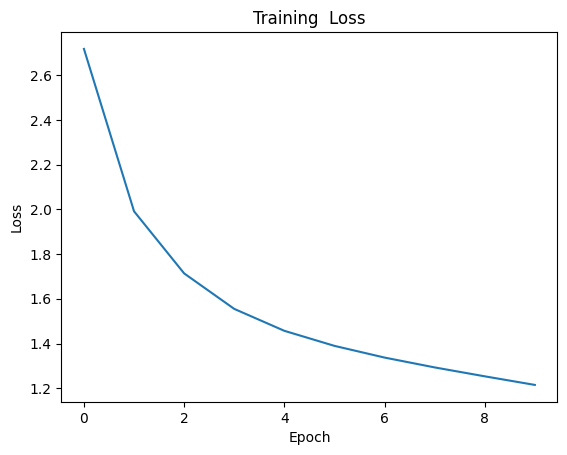

In [106]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training  Loss')
plt.show()


## Generate text

The simplest way to generate text with this model is to run it in a loop, and keep track of the model's internal state as you execute it.

![To generate text the model's output is fed back to the input](images/text_generation_sampling.png)

Each time you call the model you pass in some text and an internal state. The model returns a prediction for the next character and its new state. Pass the prediction and state back in to continue generating text.


The following makes a single step prediction:

In [107]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [108]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

Run it in a loop to generate some text. Looking at the generated text, you'll see the model knows when to capitalize, make paragraphs and imitates a Shakespeare-like writing vocabulary. With the small number of training epochs, it has not yet learned to form coherent sentences.

In [110]:
start = time.time()
states = None
# 'ROMEO:' to 'JULIET:', then to 'HAMLET:’, then to “MACBETH:’, then to 'OTHELLO:'. 
next_char = tf.constant(['ROMEO:', 'JULIET:', 'HAMLET:', 'MACBETH:', 'OTHELLO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:MILitiss of drawn. If you of, make out\nThe heart I'll give them that you of that wander\nWhilst I I have come enserverence, or a speak, if my dusy:\nYour eluse man, what like him in their cause hats\none trumpets and her insalt thanks\nAgainst any equal thing,\nBe advised my confine cannot know?\n\nKATHARINA:\nHow is a pitch down the duke, and with a low\nHear not, I told them have a man-folced be witness' quiet;\nBut so to hell up flat your vault,\nMy revolting on that words remain'd thee abjest.\nNot, sir, I have my queen in bost forward.\n\nCAMILLO:\nNone, ay: says, send to have lowly chose.\n\nPOMPEY:\nPours above these sasta, mouthswer,\nWhose nothing of them had never down bassal-gone, sweet most,\nThat sadusts are Ilabt; for nothing all corructing\nMaster rorious abradies; hither was\nFlatterer than this is out.\n\nProvost:\nI sweet not: he's a dise arm,\nWith every day, hath steed my liver.\n\nKING RICHARD II:\nThen lament thou demioner, while I know\nAnd m

The resulting text has a certain coherence and narrative, which includes themes such as emotions, quarrels, fears, love, and betrayal. It presents a Shakespearean theatrical atmosphere, giving a sense of antiquity and elegance.

However, there are also some grammatical errors, incoherent words and unclear meanings in the text, which may affect the reading experience.

The easiest thing you can do to improve the results is to train it for longer (try `EPOCHS = 30`).

You can also experiment with a different start string, try adding another RNN layer to improve the model's accuracy, or adjust the temperature parameter to generate more or less random predictions.

In [46]:
EPOCHS = 30
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/30
172/172 [==============================] - 133s 769ms/step - loss: 1.1628
Epoch 2/30
172/172 [==============================] - 133s 771ms/step - loss: 1.1216
Epoch 3/30
172/172 [==============================] - 134s 773ms/step - loss: 1.0772
Epoch 4/30
172/172 [==============================] - 134s 772ms/step - loss: 1.0316
Epoch 5/30
172/172 [==============================] - 134s 773ms/step - loss: 0.9838
Epoch 6/30
172/172 [==============================] - 133s 772ms/step - loss: 0.9347
Epoch 7/30
172/172 [==============================] - 134s 772ms/step - loss: 0.8839
Epoch 8/30
172/172 [==============================] - 133s 771ms/step - loss: 0.8309
Epoch 9/30
172/172 [==============================] - 133s 772ms/step - loss: 0.7808
Epoch 10/30
172/172 [==============================] - 133s 772ms/step - loss: 0.7325
Epoch 11/30
172/172 [==============================] - 133s 770ms/step - loss: 0.6881
Epoch 12/30
172/172 [==============================] - 133s 771

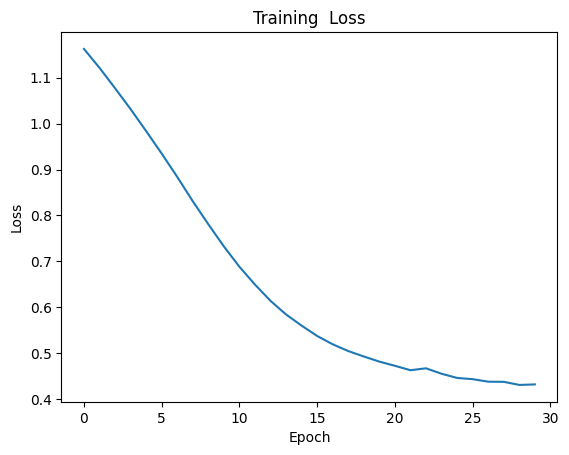

In [47]:
plt.plot(history.history['loss'], label='Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training  Loss')
plt.show()

If you want the model to generate text *faster* the easiest thing you can do is batch the text generation. In the example below the model generates 5 outputs in about the same time it took to generate 1 above. 

In [48]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [49]:
start = time.time()
states = None
# 'ROMEO:' to 'JULIET:', then to 'HAMLET:’, then to “MACBETH:’, then to 'OTHELLO:'. 
next_char = tf.constant(['ROMEO:', 'JULIET:', 'HAMLET:', 'MACBETH:', 'OTHELLO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:aking these favour\nWill that Angelo hath made you merely.\n\nSecond Gentleman:\nTo-morrow to your worship and made to my fair,\nWhich in the battle let nor harbshine.\nTalk not to me, sweet Kate, that you must\nSalute, and madmen so bright that I should not fix\nThan charge him where they live, and both such poes!\nWhat lady?\n\nPAULINA:\nGood temple!\nCome, celst, Romeo, and that can\nAboth cause but a prey nor tomage of?\n\nDUKE VINCENTIO:\nBring me to a worthieful.\n\nCAMILLO:\nWell said, me heart,\nI'll not to choose but holy Laurence' ever.\n\nGLOUCESTER:\nFor I, horson and your hurried certain to your house:\nAgainst the word is death's contempt.\n\nISABELLA:\nO, good sir, I do; a shirt at nought.\n\nFirst Senator:\nFarewell.\n\nANGELO:\nYour grandam, nor this; I hear as loath\nme hundredic; and, when awaken,\nHave the phyirnned most imperial measures.\nMy sweet care I his signories\nUpon a nature, an unusubling peace!\nAnd those would kill me to consul.\n\nF

By increasing the training time, we find that the effect is better, the loss function is smaller, and the sentences are more smooth

# Add One RNN Layer

In [50]:
class MyModelRNN(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.rnn = tf.keras.layers.SimpleRNN(rnn_units,
                                              return_sequences=True,
                                              return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
        states_gru  = self.gru.get_initial_state(x)
        states_rnn  = self.rnn.get_initial_state(x)
    x, states_gru = self.gru(x, initial_state=states_gru, training=training)
    x, states_rnn = self.rnn(x, initial_state=states_rnn, training=training)

    x = self.dense(x, training=training)

    if return_state:
      return x, [states_gru,states_rnn]
    else:
      return x

## RNN-EPOCH 10

In [52]:
modelrnn_10 = MyModelRNN(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)
modelrnn_10.compile(optimizer='adam', loss=loss)

# Directory where the checkpoints will be saved
checkpoint_dir = r'E:\rnn_tf\rnn_10_training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

EPOCHS = 10
history = modelrnn_10.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/10
172/172 [==============================] - 200s 1s/step - loss: 2.6322
Epoch 2/10
172/172 [==============================] - 198s 1s/step - loss: 1.8324
Epoch 3/10
172/172 [==============================] - 198s 1s/step - loss: 1.5592
Epoch 4/10
172/172 [==============================] - 197s 1s/step - loss: 1.4316
Epoch 5/10
172/172 [==============================] - 198s 1s/step - loss: 1.3563
Epoch 6/10
172/172 [==============================] - 104s 595ms/step - loss: 1.3031
Epoch 7/10
172/172 [==============================] - 82s 471ms/step - loss: 1.2576
Epoch 8/10
172/172 [==============================] - 81s 471ms/step - loss: 1.2168
Epoch 9/10
172/172 [==============================] - 81s 468ms/step - loss: 1.1783
Epoch 10/10
172/172 [==============================] - 81s 468ms/step - loss: 1.1375


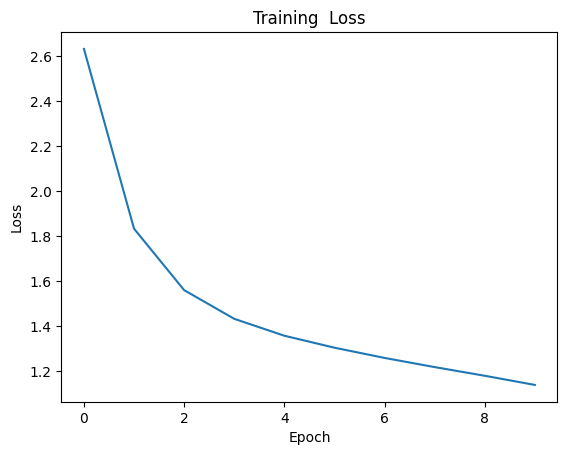

In [53]:
plt.plot(history.history['loss'], label='Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training  Loss')
plt.show()

In [54]:
one_step_model = OneStep(modelrnn_10, chars_from_ids, ids_from_chars)
start = time.time()
# 'ROMEO:' to 'JULIET:', then to 'HAMLET:’, then to “MACBETH:’, then to 'OTHELLO:'. 
next_char = tf.constant(['ROMEO:', 'JULIET:', 'HAMLET:', 'MACBETH:', 'OTHELLO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=None)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:a yolile fonthe arortre he tesis f I ter vey g aved VI lesholy.\nTI nde, illlict'sheyo se ICARARWilak\nNBus tas\n\nO:\nWAngo'\nRENKINEde ar, y thor ivichon he t tigetovema t th.\n\nCHep whishtavind mirorea thave g chidot Mucort, veat and INUS:\nWo s,\n\nLe g e homaprerourd ciarilalowioulup ly.\nFRENA:\n\nBus, w'\nD:\nAn, ave hert Cowindutho win wan llol d col br brpe aly m mon\nETHoorer t be o thil MENG-\nWhom\nBiak medy, iconcof t ivo hy;\nHo.\nTHe\nSA:\nHes ber' toul mouplts.\nTHO:\nAY berres,\nScan, nathethames-sex tche no; micher'dshe beds he, ble,\nI inief yoro?\nLICond ht f ash wavedo o wiged omyot se!\nNONAne mit trinde' for werm t ispprme m.\nWh\nTh ffal be aiksmo wstodind bry y he y n no hiveldee thilllirr stete\nLA:\nAn h my thesenganders t my restor.\nIO:\nMETICI HArupay:\nToure chupednds mbr tonthe akinding's my.\nWhandere Myod nge t Pansherseckedst;\nBBus:\n\nNGLAK:\nCUSheve alixe s h, be:\nHong'st! at cherieso unt, halde wh om s tha t.\nHe bis teng ove

## RNN-EPOCH 30

In [55]:
modelrnn_30 = MyModelRNN(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)
modelrnn_30.compile(optimizer='adam', loss=loss)

# Directory where the checkpoints will be saved
checkpoint_dir = r'E:\rnn_tf\rnn_30_training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

EPOCHS = 30
history = modelrnn_30.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/30
172/172 [==============================] - 82s 465ms/step - loss: 2.4809
Epoch 2/30
172/172 [==============================] - 81s 469ms/step - loss: 1.7335
Epoch 3/30
172/172 [==============================] - 81s 468ms/step - loss: 1.4964
Epoch 4/30
172/172 [==============================] - 81s 468ms/step - loss: 1.3886
Epoch 5/30
172/172 [==============================] - 81s 466ms/step - loss: 1.3225
Epoch 6/30
172/172 [==============================] - 81s 466ms/step - loss: 1.2709
Epoch 7/30
172/172 [==============================] - 81s 466ms/step - loss: 1.2243
Epoch 8/30
172/172 [==============================] - 81s 469ms/step - loss: 1.1822
Epoch 9/30
172/172 [==============================] - 82s 475ms/step - loss: 1.1376
Epoch 10/30
172/172 [==============================] - 88s 508ms/step - loss: 1.0937
Epoch 11/30
172/172 [==============================] - 83s 476ms/step - loss: 1.0456
Epoch 12/30
172/172 [==============================] - 83s 478ms/step - lo

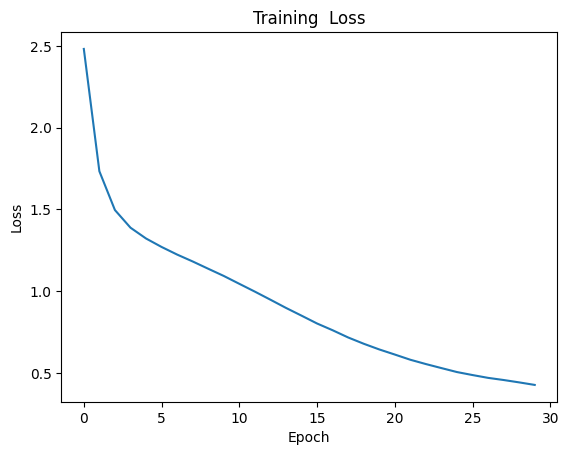

In [56]:
plt.plot(history.history['loss'], label='Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training  Loss')
plt.show()

In [57]:
one_step_model = OneStep(modelrnn_30, chars_from_ids, ids_from_chars)
start = time.time()
# 'ROMEO:' to 'JULIET:', then to 'HAMLET:’, then to “MACBETH:’, then to 'OTHELLO:'. 
next_char = tf.constant(['ROMEO:', 'JULIET:', 'HAMLET:', 'MACBETH:', 'OTHELLO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=None)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:icar thin lll, cu, sive'T:\nWAnd t, inn:\nO:\nCAMETI ang af callllllly denecish t whedathencend wng Jo'd bu warangly t\nO t\nI y icen.\n\nto whe?\nAn, t fep ous r MENo'th.\nTh y y t.\nTind powhe,\nTin hithiere,\nAneront cost we the w t than, inr\nUShar, thoveee co, theremee's ve y h g he velful?\nTHe.\nFier cthe ppathere ith m ar ve hidint trofaureer,\nO: y Ofuspl hangen t'\nTou t f t;\nII's non om'lalll ppld.\nHe blinalf llisareco an:\nPlfo nexanong ar me ar ane r t iajuth taseer! s: teithin, h kind d HOR: wond marthint yol l yonert? mer t's merou!\n\nIO:\nROfasure th gll l h sed brait! plly.\nI and vepin sthit dullllfetoup bry,\nK:\nTh heacod s, y theam thio'lan?\nRUpld s til, tomyo u sad omantes meso that,\nT:\nOMoours DUSthe ESiors h he.\nY:\nAs,\n\nPllonsoupl t f p m\nTht se fam'stupll th isot momy.\nO:\nWe lll os ICHAUMEve t yon, rent, ice sulugll tuserint m ble ar w soncrix'tithe h honowhtcth thereng y t tens d acamou thusensha ll heng, qu cout id he Wherteyo

# LSTM

In [58]:
class MyModelLSTM(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstm = tf.keras.layers.LSTM(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.lstm.get_initial_state(x)
    
    x, states_h, states_c = self.lstm(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
        return x, [states_h, states_c]
    else:
        return x

## LSTM-Epoch 10

In [59]:
modellstm_10 = MyModelLSTM(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)
modellstm_10.compile(optimizer='adam', loss=loss)

# Directory where the checkpoints will be saved
checkpoint_dir = r'E:\rnn_tf\lstm_10_training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

EPOCHS = 10
history = modellstm_10.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/10
172/172 [==============================] - 76s 428ms/step - loss: 2.8740
Epoch 2/10
172/172 [==============================] - 74s 428ms/step - loss: 2.1709
Epoch 3/10
172/172 [==============================] - 74s 430ms/step - loss: 1.9097
Epoch 4/10
172/172 [==============================] - 74s 428ms/step - loss: 1.7341
Epoch 5/10
172/172 [==============================] - 74s 428ms/step - loss: 1.6141
Epoch 6/10
172/172 [==============================] - 74s 429ms/step - loss: 1.5287
Epoch 7/10
172/172 [==============================] - 74s 430ms/step - loss: 1.4650
Epoch 8/10
172/172 [==============================] - 74s 428ms/step - loss: 1.4173
Epoch 9/10
172/172 [==============================] - 74s 429ms/step - loss: 1.3780
Epoch 10/10
172/172 [==============================] - 74s 428ms/step - loss: 1.3454


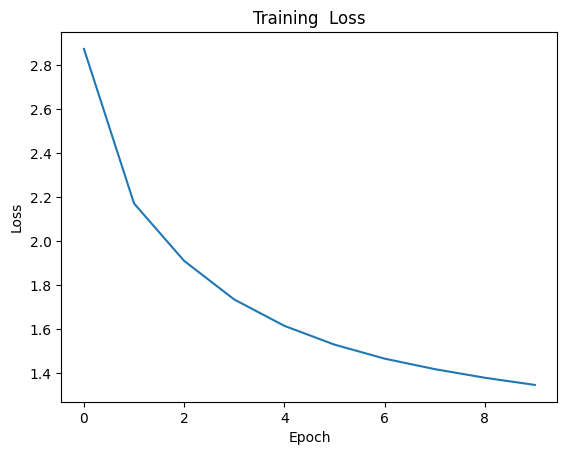

In [60]:
plt.plot(history.history['loss'], label='Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training  Loss')
plt.show()

In [61]:
one_step_model = OneStep(modellstm_10, chars_from_ids, ids_from_chars)
start = time.time()
# 'ROMEO:' to 'JULIET:', then to 'HAMLET:’, then to “MACBETH:’, then to 'OTHELLO:'. 
next_char = tf.constant(['ROMEO:', 'JULIET:', 'HAMLET:', 'MACBETH:', 'OTHELLO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=None)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:l fo arinn:\nHe hoothelonierer y piartoumang gheyotere h velou weand ale,\nym t s.\nThindrde bet y?\nTy'l IS:\nNAct HA:\nCho.\nDY\nNELU\nS:\nHENed?\nHICIRKIER:\nSerer, hy owowiobour Rantonves:\n\n\nF:\nI wablin, w:\nFIm!\nTRO:\n\nHARyouprchalore my sinothy alo thishallf whisth, ned MI fof t lo ais IZAn se ars ord?\nR:\nAS:\n\nWhel-DIERI d pamamathans heind ak bis fof l tiest, h th we.\n\nNane g I:\nCHRRD:\nA:\nO achiunod to whid-\n\nI;\nARheio g ge\nK\nULINETE bus, t, pr:\nBurkinoveveamarerrofre his y d mur o se tlyoondy ghe, anorf wint sh y ushavendir th,\nALOxy,\nIO,\nWirere, t canounde, anthel but a.\nRThe! cinon, tnerero hioua ws, w'\nANWo acu.\nPR:\n\nVAshofe torhemathe 'seawhe se ar?\nWad pst atiafor.\nacof wncl le nd',\nWINCAs RYow, kes, bou s g f lyrmalit anixenthan;\nDr IOx shanhand tous\nTurdonde wam an sendin, Anden,\nBUScours ge\nCad VUES tend sthancoveer--d ndir'le sis I hathe sofe artor HEs, th'sthorime fer\nCacustes hereveliveengobus ome, cayo burdavo

## LSTM-EPOCH 30

In [62]:
modellstm_30 = MyModelLSTM(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)
modellstm_30.compile(optimizer='adam', loss=loss)

# Directory where the checkpoints will be saved
checkpoint_dir = r'E:\rnn_tf\lstm_30_training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

EPOCHS = 30
history = modellstm_30.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/30
172/172 [==============================] - 75s 425ms/step - loss: 2.8948
Epoch 2/30
172/172 [==============================] - 74s 425ms/step - loss: 2.2946
Epoch 3/30
172/172 [==============================] - 74s 425ms/step - loss: 2.0778
Epoch 4/30
172/172 [==============================] - 74s 427ms/step - loss: 1.9076
Epoch 5/30
172/172 [==============================] - 74s 426ms/step - loss: 1.7744
Epoch 6/30
172/172 [==============================] - 74s 428ms/step - loss: 1.6693
Epoch 7/30
172/172 [==============================] - 74s 428ms/step - loss: 1.5841
Epoch 8/30
172/172 [==============================] - 74s 427ms/step - loss: 1.5172
Epoch 9/30
172/172 [==============================] - 74s 429ms/step - loss: 1.4628
Epoch 10/30
172/172 [==============================] - 74s 428ms/step - loss: 1.4191
Epoch 11/30
172/172 [==============================] - 75s 432ms/step - loss: 1.3807
Epoch 12/30
172/172 [==============================] - 75s 434ms/step - lo

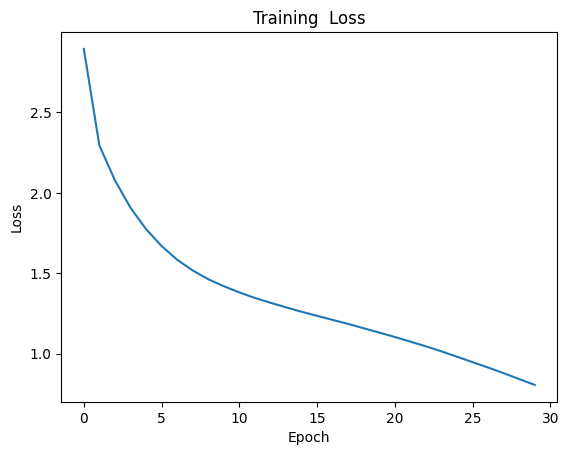

In [63]:
plt.plot(history.history['loss'], label='Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training  Loss')
plt.show()

In [64]:
one_step_model = OneStep(modellstm_30, chars_from_ids, ids_from_chars)
start = time.time()
# 'ROMEO:' to 'JULIET:', then to 'HAMLET:’, then to “MACBETH:’, then to 'OTHELLO:'. 
next_char = tf.constant(['ROMEO:', 'JULIET:', 'HAMLET:', 'MACBETH:', 'OTHELLO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=None)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:is cAcathout totacorion akeror than'OULUn,\nTO:\n\nAme,\nCYothaiog g moureseivitis,\nPAs wed th, howine tupr, gin: heroril tcay\n\nThe, cll moorous, d mus it he, he!\npare thinsto's youpl I binerd allithep'Bucanger my, sute y hof owat. NUCofow h'that m, coulloth thais su mmis mener whee lin:\n\nMit,\nk t I athea'loves! berey. todoreving?\nANofowoprt stave pr\nMI d l ke couthey s t fangrswnthave nesty men m:\nThe HASors, I; fomof welived brs ind al s an,\nINCHat blllasso, my We helounonchedete t fowhilyo'Siofalllf momithan ofe n,\nAJUCotule woit t sse, h veear gos whout towil CUCHeaf g tur:\nTRvit,\nJD:\nCURpface er't S:\nARVSATharmaril od sades My My.\nThe m f y:\n\nTh hAd bllllape fowhering t,\nMy h, sh I Madre,\nI w ng Isureelerepe mar'llfaliou wirce, h tho' thes; gren he tel d ghat thavee faillour't be st he s ur wilest t hecar mas\n\nLqula s houtherd meaverthycedat s; d y?\nAnthaimo u t HKMAn peme has' the EN:\nWhais micil t, thotoonorame ce tin chico wamortovel

## Export the generator

This single-step model can easily be [saved and restored](https://www.tensorflow.org/guide/saved_model), allowing you to use it anywhere a `tf.saved_model` is accepted.

In [65]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')


INFO:tensorflow:Assets written to: one_step\assets


INFO:tensorflow:Assets written to: one_step\assets


In [66]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ValueError: Could not find matching concrete function to call loaded from the SavedModel. Got:
  Positional arguments (2 total):
    * <tf.Tensor 'inputs:0' shape=(1,) dtype=string>
    * None
  Keyword arguments: {}

 Expected these arguments to match one of the following 1 option(s):

Option 1:
  Positional arguments (2 total):
    * TensorSpec(shape=(5,), dtype=tf.string, name='inputs')
    * None
  Keyword arguments: {}

## Advanced: Customized Training

The above training procedure is simple, but does not give you much control.
It uses teacher-forcing which prevents bad predictions from being fed back to the model, so the model never learns to recover from mistakes.

So now that you've seen how to run the model manually next you'll implement the training loop. This gives a starting point if, for example, you want to implement _curriculum  learning_ to help stabilize the model's open-loop output.

The most important part of a custom training loop is the train step function.

Use `tf.GradientTape` to track the gradients. You can learn more about this approach by reading the [eager execution guide](https://www.tensorflow.org/guide/eager).

The basic procedure is:

1. Execute the model and calculate the loss under a `tf.GradientTape`.
2. Calculate the updates and apply them to the model using the optimizer.

In [ ]:
class CustomTraining(MyModel):
  @tf.function
  def train_step(self, inputs):
      inputs, labels = inputs
      with tf.GradientTape() as tape:
          predictions = self(inputs, training=True)
          loss = self.loss(labels, predictions)
      grads = tape.gradient(loss, model.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

      return {'loss': loss}

The above implementation of the `train_step` method follows [Keras' `train_step` conventions](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit). This is optional, but it allows you to change the behavior of the train step and still use keras' `Model.compile` and `Model.fit` methods.

In [ ]:
model = CustomTraining(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [ ]:
model.fit(dataset, epochs=1)

Or if you need more control, you can write your own complete custom training loop:

In [ ]:
EPOCHS = 10

mean = tf.metrics.Mean()

for epoch in range(EPOCHS):
    start = time.time()

    mean.reset_states()
    for (batch_n, (inp, target)) in enumerate(dataset):
        logs = model.train_step([inp, target])
        mean.update_state(logs['loss'])

        if batch_n % 50 == 0:
            template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
            print(template)

    # saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.save_weights(checkpoint_prefix.format(epoch=epoch))

    print()
    print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
    print("_"*80)

model.save_weights(checkpoint_prefix.format(epoch=epoch))